# MRI Image Segmentation

##1. Setting up the Basics

In [ ]:
import os
import sys

In [ ]:
!mkdir -p /root/.kaggle/

In [ ]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p /root/.kaggle

# Upload the kaggle.json file
from google.colab import files
uploaded = files.upload()

# Move the uploaded file to the expected directory
!mv kaggle.json /root/.kaggle/


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c uw-madison-gi-tract-image-segmentation

100% 2.29G/2.30G [01:16<00:00, 31.2MB/s]
100% 2.30G/2.30G [01:16<00:00, 32.3MB/s]


In [ ]:
import zipfile

# Specify the path to the downloaded zip file
zip_file_path = '/content/uw-madison-gi-tract-image-segmentation.zip'

# Specify the directory where you want to extract the files
extract_dir = '/content/uw-madison-gi-tract-image-segmentation'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the contents of the extracted directory
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)


Extracted files: ['train.csv', 'train', 'sample_submission.csv']


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from PIL import Image
import shutil
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader
! pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from segmentation_models_pytorch.losses import JaccardLoss, SoftCrossEntropyLoss, SoftBCEWithLogitsLoss, LovaszLoss, TverskyLoss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
# This function was copied from kaggle
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [ ]:
def get_image_info(row):
  '''
  Creates a column for the case of the image, the day of the image and the
  slice of the image.
  '''
  ImageId = row['id']
  case_num = ImageId.split('_')[0].replace('case', '')
  day_num = ImageId.split('_')[1].replace('day', '')
  slice_num = ImageId.split('_')[-1].replace('slice', '')
  row['case'] = case_num
  row['day'] = day_num
  row['slice'] = slice_num

  return row

## 2 Data

###2.1 Reading the Data

In [ ]:
train_csv = pd.read_csv(r'/content/uw-madison-gi-tract-image-segmentation/train.csv')
df = train_csv.copy()
df

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


### 2.2 Cleaning and Manipulating the Data

In [ ]:
def get_image_path(row):
  '''
  Creates a column for the image_path.
  '''
  directory = f"/content/uw-madison-gi-tract-image-segmentation/train/case{row['case']}/case{row['case']}_day{row['day']}/scans/"
  slices = sorted(os.listdir(directory))
  for slice_ in slices:
      slice_num = slice_.split('_')[1]
      if slice_num == row['slice']:
          row['image_path'] = os.path.join(directory, slice_)

  return row

In [ ]:
def get_image_size(row):
  '''
  Creates a column for the image height and image width.
  '''
  path = row['image_path']
  width = path.split('_')[-4]
  heigth = path.split('_')[-3]
  row['image_height'] = heigth
  row['image_width'] = width

  return row


In [ ]:
def get_mask(ImageId, masks_df):
  '''Creates the mask of an image based on its Image_id. Takes the image id and
  a DataFrame containing RLE encoded masks as the input. Returns the mask'''
  colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

  current_image = masks_df[masks_df['id'] == ImageId]
  size = (current_image['image_height'].values[0], current_image['image_width'].values[0])

  mask_shape = (int(size[0]), int(size[1]), 3) # 3 channels for 3 classes
  mask = np.zeros(mask_shape, dtype=np.uint8)

  for i, organ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
      organ_df = current_image[current_image['class'] == organ]
      if organ_df.empty:    # In case we do not have any segmentation
          continue
      rle_encoded_segmentation = organ_df['segmentation'].values[0]
      decoded_mask = rle_decode(rle_encoded_segmentation, mask_shape[:2])
      color = colors[i]
      color = np.array(color, dtype=np.uint8)
      colored_mask = np.zeros_like(mask[:, :, 0])

      # Assigning the colors
      for channel in range(3):
          colored_mask += decoded_mask * color[channel]

      mask[:, :, i] += colored_mask.astype(np.uint8)

  return mask


In [ ]:
df3 = train_csv.copy()
df3.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:
df3 = df3.apply(get_image_info, axis=1)
df3.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001
2,case123_day20_slice_0001,stomach,NaN,123,20,0001
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002


In [ ]:
df3 = df3.apply(get_image_path, axis=1)
df3.head()

,id,class,segmentation,case,day,slice,image_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...


In [ ]:
df3 = df3.apply(get_image_size, axis=1)
df3.head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266


In [ ]:
os.mkdir('/content/uw-madison-gi-tract-image-segmentation/masks_3')

In [ ]:
# Creating a DataFrame containing the RLE encoded segmenations
masks_3 = df3[df3['segmentation'].notnull()].copy()
masks_3

,id,class,segmentation,case,day,slice,image_path,image_height,image_width
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065,/content/uw-madison-gi-tract-image-segmentatio...,266,266
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066,/content/uw-madison-gi-tract-image-segmentatio...,266,266
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067,/content/uw-madison-gi-tract-image-segmentatio...,266,266
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068,/content/uw-madison-gi-tract-image-segmentatio...,266,266
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069,/content/uw-madison-gi-tract-image-segmentatio...,266,266
...,...,...,...,...,...,...,...,...,...
115459,case30_day0_slice_0135,small_bowel,22540 1 22804 5 23069 7 23334 10 23600 11 2386...,30,0,0135,/content/uw-madison-gi-tract-image-segmentatio...,266,266
115461,case30_day0_slice_0136,large_bowel,18746 7 19009 23 19038 7 19273 44 19537 49 198...,30,0,0136,/content/uw-madison-gi-tract-image-segmentatio...,266,266
115462,case30_day0_slice_0136,small_bowel,23079 1 23343 6 23608 9 23874 11 24139 13 2440...,30,0,0136,/content/uw-madison-gi-tract-image-segmentatio...,266,266
115464,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 1953...,30,0,0137,/content/uw-madison-gi-tract-image-segmentatio...,266,266


In [ ]:
# Create the mask where applicable
for ImageId in masks_3['id'].values:
  mask = get_mask(ImageId, masks_3)
  mask_path = f'/content/uw-madison-gi-tract-image-segmentation/masks_3/{ImageId}.png'
  cv2.imwrite(mask_path, mask)

In [ ]:
# Create empty masks
mask_266 = np.zeros((266, 266, 3), dtype=np.uint8)
mask_360 = np.zeros((310, 360, 3), dtype=np.uint8)
mask_234 = np.zeros((234, 234, 3), dtype=np.uint8)
mask_276 = np.zeros((276, 276, 3), dtype=np.uint8)

mask_path_266 = f"/content/uw-madison-gi-tract-image-segmentation/masks_3/empty_mask_266.png"
mask_path_360 = f"/content/uw-madison-gi-tract-image-segmentation/masks_3/empty_mask_360.png"
mask_path_234 = f"/content/uw-madison-gi-tract-image-segmentation/masks_3/empty_mask_234.png"
mask_path_276 = f"/content/uw-madison-gi-tract-image-segmentation/masks_3/empty_mask_276.png"

cv2.imwrite(mask_path_266, mask_266)
cv2.imwrite(mask_path_360, mask_360)
cv2.imwrite(mask_path_234, mask_234)
cv2.imwrite(mask_path_276, mask_276)

True

In [ ]:
# Create a column containing the mask path where we have a mask
df3['mask_path'] = df3['id'].apply(lambda x: f"/content/uw-madison-gi-tract-image-segmentation/masks_3/{x}.png" if x in masks_3['id'].values else np.nan)
df3.head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,NaN
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,NaN
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,NaN
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,NaN
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,NaN


In [ ]:
df3['image_height'].unique()

array(['266', '310', '234', '276'], dtype=object)

In [ ]:
# Assigning the empty mask to all entries with NaN segmentation
nomask_ids_3 = df3[df3['mask_path'].isnull()]['id'].values

for index, row in df3.iterrows():
    if row['id'] in nomask_ids_3:
        if row['image_height'] == '266':
            df3.at[index, 'mask_path'] = mask_path_266
        elif row['image_height'] == '310':
            df3.at[index, 'mask_path'] = mask_path_360
        elif row['image_height'] == '234':
            df3.at[index, 'mask_path'] = mask_path_234
        elif row['image_height'] == '276':
            df3.at[index, 'mask_path'] = mask_path_276

df3.head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...


In [ ]:
df_266 = df3[df3['image_height'] == '266']
df_266[250:].head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
250,case123_day20_slice_0084,small_bowel,21436 4 21701 7 21966 9 22231 11 22497 12 2276...,123,20,0084,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
251,case123_day20_slice_0084,stomach,11045 14 11308 19 11572 23 11838 24 12103 27 1...,123,20,0084,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
252,case123_day20_slice_0085,large_bowel,16950 2 17214 7 17479 10 17491 4 17744 19 1800...,123,20,0085,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
253,case123_day20_slice_0085,small_bowel,21435 7 21699 10 21965 11 22230 13 22496 14 22...,123,20,0085,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
254,case123_day20_slice_0085,stomach,11043 16 11307 20 11572 23 11837 25 12102 27 1...,123,20,0085,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...


In [ ]:
df_266[df_266['id'] == 'case123_day20_slice_0082'].mask_path.values[0]

'/content/uw-madison-gi-tract-image-segmentation/masks_3/case123_day20_slice_0082.png'

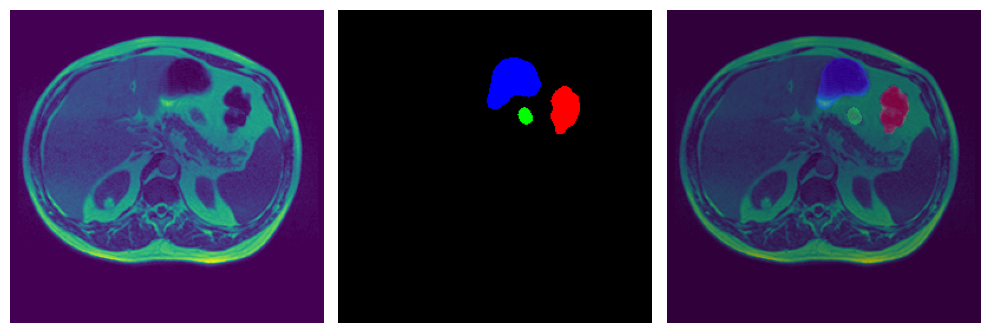

In [ ]:
# Visualizing an example for 266x266 images
#df_266[df_266['id'] == 'case123_day20_slice_0082']
fig, axes = plt.subplots(1, 3, figsize=(10, 15))
test_mask_path = df_266[df_266['id'] == 'case123_day20_slice_0082'].mask_path.values[0]
test_img_path = df_266[df_266['id'] == 'case123_day20_slice_0082'].image_path.values[0]
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_UNCHANGED)

axes[0].imshow(test_img)
axes[0].axis('off')

axes[1].imshow(test_mask)
axes[1].axis('off')

axes[2].imshow(test_img)
axes[2].imshow(test_mask, alpha=0.3)
axes[2].axis('off')

plt.tight_layout()
plt.show()

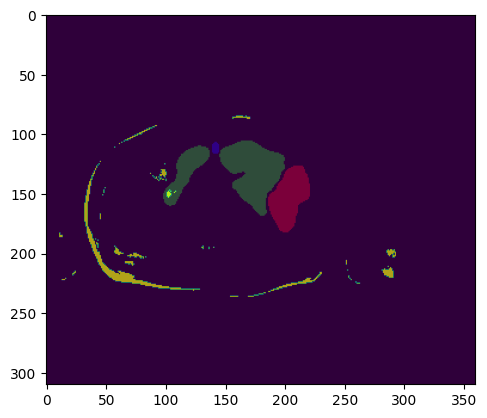

In [ ]:
# Visualizing an example for the 310x360 images (They look weird)
df_310 = df3[df3['image_height'] == '310']

#case133_day0_slice_0067
#case41_day0_slice_0075

test_mask_path = df_310[df_310['id'] == 'case129_day27_slice_0090'].mask_path.values[0]
test_img_path = df_310[df_310['id'] == 'case129_day27_slice_0090'].image_path.values[0]
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_COLOR)

plt.imshow(test_img)
plt.imshow(test_mask, alpha=0.3)

plt.show()

In [ ]:
df_310[df_310['segmentation'].notnull()].iloc[1000:1100]

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
5521,case129_day0_slice_0113,small_bowel,40097 3 40455 21 40794 3 40802 36 41150 50 415...,129,0,0113,/content/uw-madison-gi-tract-image-segmentatio...,310,360,/content/uw-madison-gi-tract-image-segmentatio...
5523,case129_day0_slice_0114,large_bowel,43288 3 43646 9 44004 12 44363 15 44722 17 450...,129,0,0114,/content/uw-madison-gi-tract-image-segmentatio...,310,360,/content/uw-madison-gi-tract-image-segmentatio...
5524,case129_day0_slice_0114,small_bowel,40098 1 40455 14 40474 1 40803 35 41153 47 415...,129,0,0114,/content/uw-madison-gi-tract-image-segmentatio...,310,360,/content/uw-madison-gi-tract-image-segmentatio...
5526,case129_day0_slice_0115,large_bowel,43646 8 44004 12 44363 14 44722 16 45081 18 45...,129,0,0115,/content/uw-madison-gi-tract-image-segmentatio...,310,360,/content/uw-madison-gi-tract-image-segmentatio...
5527,case129_day0_slice_0115,small_bowel,40455 12 40806 24 40834 3 41154 46 41511 50 41...,129,0,0115,/content/uw-madison-gi-tract-image-segmentatio...,310,360,/content/uw-madison-gi-tract-image-segmentatio...
...,...,...,...,...,...,...,...,...,...,...
5883,case129_day27_slice_0090,large_bowel,45928 8 46286 11 46644 13 47003 15 47362 16 47...,129,27,0090,/content/uw-madison-gi-tract-image-segmentatio...,310,360,/content/uw-madison-gi-tract-image-segmentatio...
5884,case129_day27_slice_0090,small_bowel,38324 10 38681 15 39039 19 39397 22 39728 3 39...,129,27,0090,/content/uw-madison-gi-tract-image-segmentatio...,310,360,/content/uw-madison-gi-tract-image-segmentatio...
5885,case129_day27_slice_0090,stomach,38662 2 39021 4 39380 6 39740 6 40100 6 40460 ...,129,27,0090,/content/uw-madison-gi-tract-image-segmentatio...,310,360,/content/uw-madison-gi-tract-image-segmentatio...
5886,case129_day27_slice_0091,large_bowel,43665 5 44024 7 44383 9 44742 11 45102 11 4546...,129,27,0091,/content/uw-madison-gi-tract-image-segmentatio...,310,360,/content/uw-madison-gi-tract-image-segmentatio...


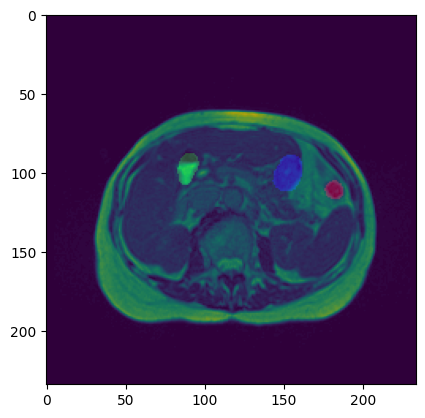

In [ ]:
# Visualizing an example of the 234x234 images
df_234 = df3[df3['image_height'] == '234']

#case139_day0_slice_0078

test_mask_path = df_234[df_234['id'] == 'case139_day0_slice_0078'].mask_path.values[0]
test_img_path = df_234[df_234['id'] == 'case139_day0_slice_0078'].image_path.values[0]
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_COLOR)

plt.imshow(test_img)
plt.imshow(test_mask, alpha=0.3)
#print(test_mask_path)
plt.show()

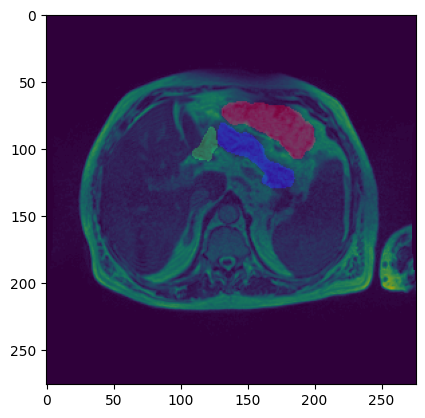

In [ ]:
# Visualizing an example of a 276x276 image
df_276 = df3[df3['image_height'] == '276']

test_mask_path = df_276[df_276['id'] == 'case118_day0_slice_0037'].mask_path.values[0]
test_img_path = df_276[df_276['id'] == 'case118_day0_slice_0037'].image_path.values[0]
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_COLOR)

plt.imshow(test_img)
plt.imshow(test_mask, alpha=0.3)
#print(test_mask_path)
plt.show()

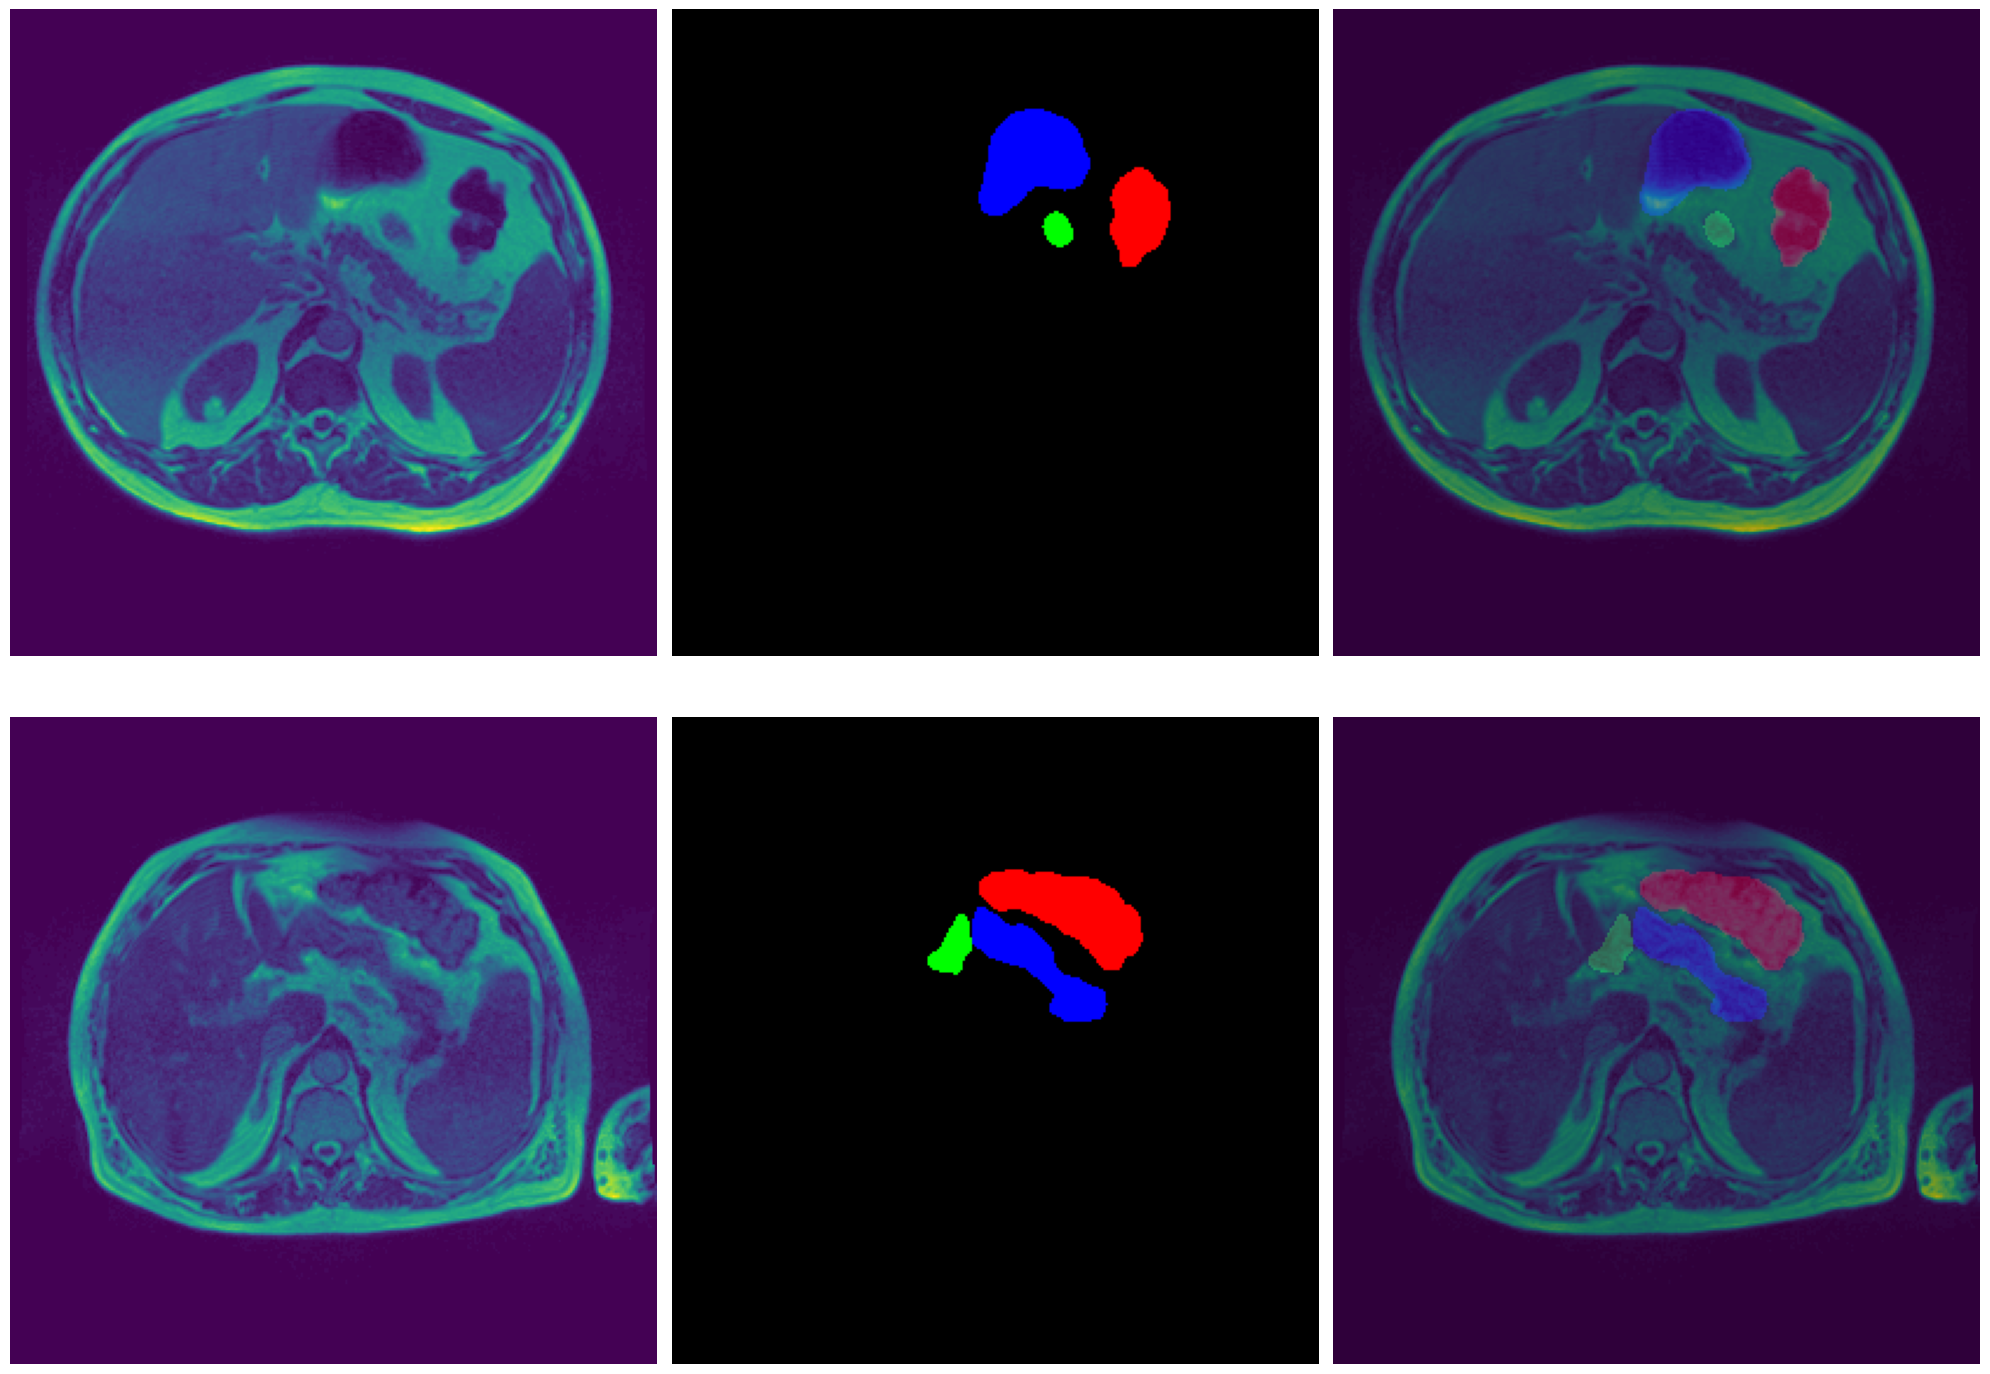

In [ ]:
# Visualizing an example for presentation
#df_266[df_266['id'] == 'case123_day20_slice_0082']
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
test_mask_path = df_266[df_266['id'] == 'case123_day20_slice_0082'].mask_path.values[0]
test_img_path = df_266[df_266['id'] == 'case123_day20_slice_0082'].image_path.values[0]
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_UNCHANGED)

df_276 = df3[df3['image_height'] == '276']

test_mask_path2 = df_276[df_276['id'] == 'case118_day0_slice_0037'].mask_path.values[0]
test_img_path2 = df_276[df_276['id'] == 'case118_day0_slice_0037'].image_path.values[0]
test_img2 = cv2.imread(test_img_path2, cv2.IMREAD_GRAYSCALE)
test_mask2 = cv2.imread(test_mask_path2, cv2.IMREAD_COLOR)

axes[0, 0].imshow(test_img)
axes[0, 0].axis('off')

axes[0, 1].imshow(test_mask)
axes[0, 1].axis('off')

axes[0, 2].imshow(test_img)
axes[0, 2].imshow(test_mask, alpha=0.3)
axes[0, 2].axis('off')

axes[1, 0].imshow(test_img2)
axes[1, 0].axis('off')

axes[1, 1].imshow(test_mask2)
axes[1, 1].axis('off')

axes[1, 2].imshow(test_img2)
axes[1, 2].imshow(test_mask2, alpha=0.3)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

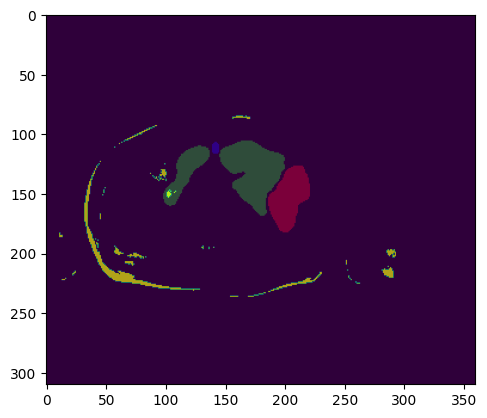

In [ ]:
# Visualizing an example for the 310x360 images (They look weird)
df_310 = df3[df3['image_height'] == '310']

#case133_day0_slice_0067
#case41_day0_slice_0075

test_mask_path = df_310[df_310['id'] == 'case129_day27_slice_0090'].mask_path.values[0]
test_img_path = df_310[df_310['id'] == 'case129_day27_slice_0090'].image_path.values[0]
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_COLOR)

plt.imshow(test_img)
plt.imshow(test_mask, alpha=0.3)

plt.show()

As some of the 310x360 pictures look like this I decided to remove them from the dataset as I believe they mislead the model and are wrong data.

Creating a DataFrame containing those cases where we have segmentation for all three organs.

### 2.3 Final train/val/test DataFrames

In [ ]:
all_three_organs_ids = []

for element in masks_3['id'].unique().tolist():
  count = masks_3['id'].values.tolist().count(element)
  if count == 3:
    all_three_organs_ids.append(element)

print(all_three_organs_ids)

['case123_day20_slice_0082', 'case123_day20_slice_0083', 'case123_day20_slice_0084', 'case123_day20_slice_0085', 'case123_day20_slice_0086', 'case123_day20_slice_0087', 'case123_day20_slice_0088', 'case123_day20_slice_0089', 'case123_day20_slice_0090', 'case123_day20_slice_0091', 'case123_day20_slice_0092', 'case123_day20_slice_0093', 'case123_day20_slice_0094', 'case123_day20_slice_0095', 'case123_day20_slice_0096', 'case123_day22_slice_0083', 'case123_day22_slice_0084', 'case123_day22_slice_0085', 'case123_day22_slice_0086', 'case123_day22_slice_0087', 'case123_day22_slice_0088', 'case123_day22_slice_0089', 'case123_day22_slice_0090', 'case123_day22_slice_0091', 'case123_day22_slice_0092', 'case123_day22_slice_0093', 'case123_day22_slice_0094', 'case123_day22_slice_0095', 'case123_day22_slice_0096', 'case123_day22_slice_0097', 'case123_day22_slice_0098', 'case123_day22_slice_0099', 'case123_day22_slice_0100', 'case123_day0_slice_0071', 'case123_day0_slice_0072', 'case123_day0_slice_0

In [ ]:
len(all_three_organs_ids)

3201

In [ ]:
all_three_organs_df = df3[df3['id'].isin(all_three_organs_ids)]
all_three_organs_df['case'].unique()

array(['123', '77', '133', '129', '139', '130', '88', '44', '145', '15',
       '110', '42', '118', '66', '91', '142', '58', '63', '114', '102',
       '115', '65', '53', '122', '125', '117', '140', '134', '9', '113',
       '90', '49', '19', '6', '67', '154', '135', '84', '147', '101', '7',
       '119', '32', '24', '33', '22', '149', '11', '148', '124', '111',
       '89', '136', '116', '143', '35', '108', '43', '55', '141', '92',
       '16', '131', '81', '34', '36', '20', '121', '29', '18', '138',
       '146', '144', '40', '54', '78', '47', '156', '85', '107', '41',
       '80', '2', '74', '30'], dtype=object)

In [ ]:
train_cases, validation_cases = train_test_split(all_three_organs_df['case'].unique().tolist(), random_state=42)
print(train_cases)
print(validation_cases)

['101', '9', '15', '34', '130', '22', '49', '67', '33', '30', '58', '36', '44', '18', '108', '102', '138', '117', '116', '66', '16', '129', '63', '147', '145', '121', '88', '135', '47', '131', '111', '149', '74', '142', '134', '119', '55', '140', '148', '125', '24', '80', '78', '43', '19', '41', '141', '81', '40', '84', '113', '77', '136', '65', '133', '122', '107', '54', '115', '92', '146', '91', '89']
['85', '123', '29', '53', '118', '2', '110', '114', '139', '20', '7', '11', '154', '144', '35', '143', '6', '156', '32', '124', '42', '90']


In [ ]:
three_organ_train_df = all_three_organs_df[all_three_organs_df['case'].isin(train_cases)]
three_organ_validation_df = all_three_organs_df[all_three_organs_df['case'].isin(validation_cases)]

In [ ]:
three_organ_train_df_test = three_organ_train_df[three_organ_train_df['image_height'].isin(['266', '276', '234'])]
three_organ_train_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4821 entries, 1983 to 115436
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            4821 non-null   object
 1   class         4821 non-null   object
 2   segmentation  4821 non-null   object
 3   case          4821 non-null   object
 4   day           4821 non-null   object
 5   slice         4821 non-null   object
 6   image_path    4821 non-null   object
 7   image_height  4821 non-null   object
 8   image_width   4821 non-null   object
 9   mask_path     4821 non-null   object
dtypes: object(10)
memory usage: 414.3+ KB


In [ ]:
os.listdir('/content/uw-madison-gi-tract-image-segmentation/')

['train.csv', 'masks_3', 'train', 'sample_submission.csv']

In [ ]:
three_organ_train_df['image_height'].unique()

array(['266', '310', '276'], dtype=object)

In [ ]:
three_organ_validation_df['image_height'].unique()

array(['266', '234', '310', '276'], dtype=object)

In [ ]:
df3.head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...


In [ ]:
only_organs_df = df3[df3['segmentation'].notnull()]
only_organs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33913 entries, 194 to 115465
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
 3   case          33913 non-null  object
 4   day           33913 non-null  object
 5   slice         33913 non-null  object
 6   image_path    33913 non-null  object
 7   image_height  33913 non-null  object
 8   image_width   33913 non-null  object
 9   mask_path     33913 non-null  object
dtypes: object(10)
memory usage: 2.8+ MB


In [ ]:
only_organ_train_df = only_organs_df[only_organs_df['case'].isin(train_cases)]
only_organ_train_df.head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
1541,case77_day20_slice_0082,stomach,24675 10 24939 13 25204 15 25469 17 25735 17 2...,77,20,0082,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1544,case77_day20_slice_0083,stomach,24145 7 24408 12 24673 14 24937 17 25202 18 25...,77,20,0083,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1547,case77_day20_slice_0084,stomach,23614 8 23878 12 24143 14 24407 17 24672 18 24...,77,20,0084,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1550,case77_day20_slice_0085,stomach,23346 9 23610 12 23875 14 24140 16 24405 18 24...,77,20,0085,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1553,case77_day20_slice_0086,stomach,21450 10 21712 14 21974 18 22238 21 22501 24 2...,77,20,0086,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...


In [ ]:
only_organ_validation_df = only_organs_df[only_organs_df['case'].isin(validation_cases)]
only_organ_validation_df.head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...


In [ ]:
only_organ_validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9088 entries, 194 to 112399
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            9088 non-null   object
 1   class         9088 non-null   object
 2   segmentation  9088 non-null   object
 3   case          9088 non-null   object
 4   day           9088 non-null   object
 5   slice         9088 non-null   object
 6   image_path    9088 non-null   object
 7   image_height  9088 non-null   object
 8   image_width   9088 non-null   object
 9   mask_path     9088 non-null   object
dtypes: object(10)
memory usage: 781.0+ KB


In [ ]:
only_organ_validation_df = only_organ_validation_df[only_organ_validation_df['image_height'].isin(['266', '276', '234'])]
only_organ_validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7311 entries, 194 to 112399
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7311 non-null   object
 1   class         7311 non-null   object
 2   segmentation  7311 non-null   object
 3   case          7311 non-null   object
 4   day           7311 non-null   object
 5   slice         7311 non-null   object
 6   image_path    7311 non-null   object
 7   image_height  7311 non-null   object
 8   image_width   7311 non-null   object
 9   mask_path     7311 non-null   object
dtypes: object(10)
memory usage: 628.3+ KB


In [ ]:
only_organ_validation_df['image_height'].unique()

array(['266', '234', '310', '276'], dtype=object)

In [ ]:
only_organ_train_df = only_organ_train_df[only_organ_train_df['image_height'].isin(['266', '276', '234'])]
only_organ_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16691 entries, 1541 to 115465
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            16691 non-null  object
 1   class         16691 non-null  object
 2   segmentation  16691 non-null  object
 3   case          16691 non-null  object
 4   day           16691 non-null  object
 5   slice         16691 non-null  object
 6   image_path    16691 non-null  object
 7   image_height  16691 non-null  object
 8   image_width   16691 non-null  object
 9   mask_path     16691 non-null  object
dtypes: object(10)
memory usage: 1.4+ MB


In [ ]:
only_empty = df3[df3['segmentation'].isnull()]
only_empty.head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...


In [ ]:
only_empty_train = only_empty[only_empty['case'].isin(train_cases)]
only_empty_val = only_empty[only_empty['case'].isin(validation_cases)]

In [ ]:
only_empty_train.head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
1296,case77_day20_slice_0001,large_bowel,NaN,77,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1297,case77_day20_slice_0001,small_bowel,NaN,77,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1298,case77_day20_slice_0001,stomach,NaN,77,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1299,case77_day20_slice_0002,large_bowel,NaN,77,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1300,case77_day20_slice_0002,small_bowel,NaN,77,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...


In [ ]:
only_empty_val.head()

,id,class,segmentation,case,day,slice,image_path,image_height,image_width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/uw-madison-gi-tract-image-segmentatio...,266,266,/content/uw-madison-gi-tract-image-segmentatio...


In [ ]:
sample_train_empty = only_empty_train.sample(100, random_state=42)
#sample_val_empty = only_empty_val.sample(300, random_state=42)

balanced_train_df = pd.concat([only_organ_train_df, sample_train_empty])
#balanced_val_df = pd.concat([only_organ_validation_df, sample_val_empty])
val_df = pd.concat([only_organ_validation_df, only_empty_val])

In [ ]:
balanced_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16791 entries, 1541 to 26734
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            16791 non-null  object
 1   class         16791 non-null  object
 2   segmentation  16691 non-null  object
 3   case          16791 non-null  object
 4   day           16791 non-null  object
 5   slice         16791 non-null  object
 6   image_path    16791 non-null  object
 7   image_height  16791 non-null  object
 8   image_width   16791 non-null  object
 9   mask_path     16791 non-null  object
dtypes: object(10)
memory usage: 1.4+ MB


In [ ]:
balanced_val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7611 entries, 194 to 57142
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7611 non-null   object
 1   class         7611 non-null   object
 2   segmentation  7311 non-null   object
 3   case          7611 non-null   object
 4   day           7611 non-null   object
 5   slice         7611 non-null   object
 6   image_path    7611 non-null   object
 7   image_height  7611 non-null   object
 8   image_width   7611 non-null   object
 9   mask_path     7611 non-null   object
dtypes: object(10)
memory usage: 654.1+ KB


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29231 entries, 194 to 112463
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            29231 non-null  object
 1   class         29231 non-null  object
 2   segmentation  7311 non-null   object
 3   case          29231 non-null  object
 4   day           29231 non-null  object
 5   slice         29231 non-null  object
 6   image_path    29231 non-null  object
 7   image_height  29231 non-null  object
 8   image_width   29231 non-null  object
 9   mask_path     29231 non-null  object
dtypes: object(10)
memory usage: 2.5+ MB


In [ ]:
val_df = val_df.sample(10000, random_state=42)
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 53015 to 112147
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            10000 non-null  object
 1   class         10000 non-null  object
 2   segmentation  2463 non-null   object
 3   case          10000 non-null  object
 4   day           10000 non-null  object
 5   slice         10000 non-null  object
 6   image_path    10000 non-null  object
 7   image_height  10000 non-null  object
 8   image_width   10000 non-null  object
 9   mask_path     10000 non-null  object
dtypes: object(10)
memory usage: 859.4+ KB


## 3. Model Building

Please note that the models have been loaded from checkpoints, to save progress thus the notebook is set up accordingly.

## 3.1 Model Parameters

In [ ]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-6
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
NUM_EPOCHS = 5  # The model was trained systematically, but to reach current state it required about ~30 epochs (around 1hr)
NUM_WORKERS = 4
IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384
PIN_MEMORY = True
LOAD_MODEL = False
IN_CHANNELS = 1
NUM_CLASSES = 3
#TRAIN_DF = three_organ_train_df
#VAL_DF = three_organ_validation_df
#TRAIN_DF = only_organ_train_df
#VAL_DF = only_organ_validation_df
TRAIN_DF = balanced_train_df
#VAL_DF = balanced_val_df
VAL_DF = val_df

In [ ]:
DEVICE

'cuda'

## 3.2 Model Utils

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        self.image_paths = df["image_path"].tolist()
        self.mask_paths = df["mask_path"].tolist()
        #self.num_classes = num_classes

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        #image = np.array(Image.open(img_path), dtype=np.float32)
        # Strandardize the image (it might be already in a 1-0 scale)
        #max_image = np.max(image)
        #if max_image:
        #  image /= max_image
        # Standardize the RGB mask
        #mask = np.array(Image.open(mask_path).convert('RGB'), dtype=np.float32) / 255.0
        image = np.array(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), dtype=np.float32)
        max_image = np.max(image)
        if max_image:
          image /= max_image

        mask = np.array(cv2.imread(mask_path, cv2.IMREAD_COLOR), dtype=np.float32) / 255.0

        if self.transforms is not None:
          # Apply the augmentations
          augmentations = self.transforms(image=image, mask=mask)
          image = np.array(augmentations["image"], dtype=np.float32)
          mask = np.array(augmentations["mask"], dtype=np.float32)

        return image, mask


In [ ]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        ToTensorV2(),
    ]
)

validation_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ]
)

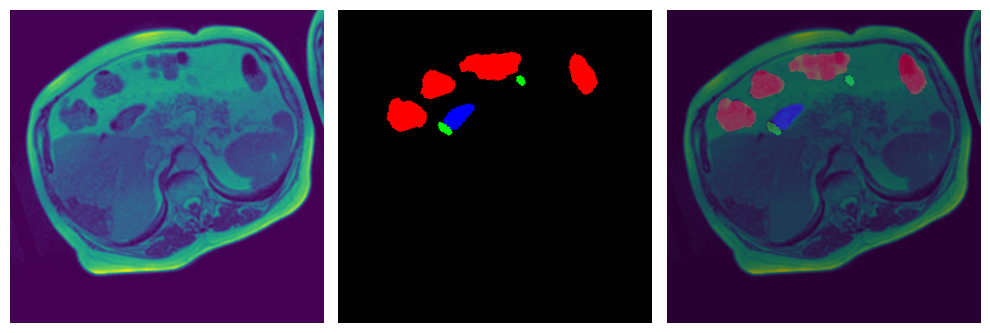

In [ ]:
custom_dataset = CustomDataset(TRAIN_DF, train_transform)

fig, axes = plt.subplots(1, 3, figsize=(10, 15))

image, mask = custom_dataset[1522]
image = image.transpose((1, 2, 0))
#mask = mask.transpose((1, 2, 0))
axes[0].imshow(image)
axes[0].axis('off')

axes[1].imshow(mask)
axes[1].axis('off')

axes[2].imshow(image)
axes[2].imshow(mask, alpha = 0.4)
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def save_checkpoint(state, filename="/content/uw-madison-gi-tract-image-segmentation/checkpoints/full_checkpoint4.pth.tar"):
  'Saves a model checkpoint'
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint_from_path(model, filename, folder_path='/content/uw-madison-gi-tract-image-segmentation/checkpoints'):
  '''Loades a model checkpoint from a path'''
  print("=> Loading checkpoint from path")
  checkpoint_path = os.path.join(folder_path, filename)
  checkpoint = torch.load(checkpoint_path)
  model_state_dict = checkpoint['state_dict']
  model.load_state_dict(model_state_dict)

def get_loaders(
    train_df,
    val_df,
    batch_size,
    train_transform,
    val_transform,
    num_workers=2,
    pin_memory=True
):
  '''Creates the Train- and Validation loaders.'''
  train_ds = CustomDataset(
      train_df,
      transforms=train_transform
  )

  train_loader = DataLoader(
      train_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=True,
  )

  val_ds = CustomDataset(
      val_df,
      transforms=val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=False,
  )

  return train_loader, val_loader

jaccard_loss = JaccardLoss(mode='multilabel')
dice_loss = DiceLoss(mode='multilabel')
bce_loss = SoftBCEWithLogitsLoss()
tversky_loss = TverskyLoss(mode='multilabel', log_loss=False)

def dice_coefficient(y_true, y_pred, threshold=0.5, dimension=(2,3), epsilon=0.001):
  '''Calculates the dice coefficient'''
  y_true = y_true.to(torch.float32)
  y_pred = (y_pred>threshold).to(torch.float32)
  intersection = (y_true*y_pred).sum(dim=dimension)
  den = y_true.sum(dim=dimension) + y_pred.sum(dim=dimension)
  dice = ((2*intersection+epsilon)/(den+epsilon)).mean(dim=(1,0))
  return dice

def i_o_u_coefficient(y_true, y_pred, threshold=0.5, dimension=(2,3), epsilon=0.001):
  '''Calculates the intersection over union (jaccard)'''
  y_true = y_true.to(torch.float32)
  y_pred = (y_pred>threshold).to(torch.float32)
  intersection = (y_true*y_pred).sum(dim=dimension)
  union = (y_true + y_pred - y_true*y_pred).sum(dim=dimension)
  intersection_over_union = ((intersection+epsilon)/(union+epsilon)).mean(dim=(1,0))
  return intersection_over_union

# After failed experimentation suggested by ChatGPT
def custom_loss_function(y_pred, y_true):
  '''Custom loss function. Calculates the average of the Binary Cross Entropy Loss,
  and the Tversky Loss.
  '''
  return 0.5*bce_loss(y_pred, y_true) + 0.5*tversky_loss(y_pred, y_true)

def save_predictions_as_imgs(loader, model, threshold, folder="saved_images2/", device=DEVICE):
  '''
  Save and visualize the predictions as images. Requires the loader, the model, the threshold, the folder
  and the device as inputs.
  '''
  model.eval()
  for idx, (x, y) in enumerate(loader):
      #print('data shape:', x.shape, 'data dtype:', x.dtype)
      #print('target shape:', y.shape, 'target dtype:', y.dtype)
      x = x.to(device=device)
      y = y.to(device = device)
      #y = y.unsqueeze(1)
      y = y.permute(0, 3, 1, 2)
      with torch.no_grad():
          preds = torch.sigmoid(model(x))
          preds = (preds > threshold).float()

      #print('prediciton shape:', preds.shape)
      torchvision.utils.save_image(preds, f"/content/uw-madison-gi-tract-image-segmentation/{folder}/pred_{idx}.png")
      torchvision.utils.save_image(y, f"/content/uw-madison-gi-tract-image-segmentation/{folder}/target_{idx}.png")

  model.train()

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler, scheduler):
  '''
  Training function. Takes the training loader, the model, the optimizer, the
  loss function, the scaler and the scheduler as parameters. Trains one epoch.
  Returns the loss over the whole epoch.
  '''
  model.train()
  loop = tqdm(loader)

  n = 0
  total_loss = 0.0

  for batch_idx, (data, targets) in enumerate(loop):
      data = data.to(device=DEVICE, dtype=torch.float)
      targets = targets.to(device=DEVICE, dtype=torch.float)
      targets = targets.permute(0, 3, 1, 2)

      batch_size = data.size(0)

      # Forward pass
      with torch.cuda.amp.autocast(enabled=True):
        predictions = model(data)
        predictions = predictions.squeeze(1)
        loss = loss_fn(predictions, targets)

      # Backward pass
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      optimizer.zero_grad()

      scheduler.step(loss)

      total_loss += (loss.item() * batch_size)
      n += batch_size

      epoch_loss = total_loss/n

      # Update tqdm loop
      loop.set_postfix(train_loss=f'{epoch_loss:0.4f}')

  torch.cuda.empty_cache()

  return epoch_loss


In [ ]:
def validation_fn(model, loader, device, loss_fn):
  '''Validation function. Calculates the validation results of the model. Takes the
  model, the validation loader the device and the loss function as parameters.
  Returns the loss over the whole epoch, as well as a tuple containing the
  dice coefficient and the intersection over union (jaccard) of the validation set.'''
  model.eval()

  n = 0
  total_loss = 0.0

  val_scores = []

  loop = tqdm(enumerate(loader), total=len(loader), desc='Valid ')
  for batch_idx, (data, targets) in loop:
    data = data.to(device=DEVICE, dtype=torch.float)
    targets = targets.to(device=DEVICE, dtype=torch.float)
    targets = targets.permute(0, 3, 1, 2)

    batch_size = targets.size(0)

    predictions = model(data)
    predictions = predictions.squeeze(1)
    loss = loss_fn(predictions, targets)

    total_loss += (loss.item() * batch_size)
    n += batch_size

    epoch_loss = total_loss / n

    predictions = torch.sigmoid(predictions)
    val_dice = dice_coefficient(targets, predictions).cpu().detach().numpy()
    val_jaccard = i_o_u_coefficient(targets, predictions).cpu().detach().numpy()
    val_scores.append([val_dice, val_jaccard])

    loop.set_postfix(valid_loss = f'{epoch_loss:0.4f}')
    val_scores = np.mean(val_scores, axis=0)

    torch.cuda.empty_cache()

    return epoch_loss, val_scores

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
os.mkdir('/content/uw-madison-gi-tract-image-segmentation/checkpoints/')

## 3.3 Model Training

In [ ]:
model = smp.Unet(encoder_name='efficientnet-b0', encoder_weights='imagenet', in_channels=IN_CHANNELS, classes=NUM_CLASSES, activation=None).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, min_lr=1e-6)
train_loader, val_loader = get_loaders(
    TRAIN_DF,
    VAL_DF,
    BATCH_SIZE,
    train_transform,
    validation_transform,
    NUM_WORKERS,
    PIN_MEMORY,
)
loss_fn = custom_loss_function

scaler = torch.cuda.amp.GradScaler()
if True:
  load_checkpoint_from_path(model, filename='full_checkpoint3.pth.tar')

for epoch in range(NUM_EPOCHS):
  print(f"Epoch {epoch+1}/{NUM_EPOCHS},")
  train_loss = train_fn(loader=train_loader, model=model, optimizer=optimizer, loss_fn=loss_fn,
                        scaler=scaler, scheduler=scheduler)

  val_loss, val_scores = validation_fn(model=model, loader=val_loader, device=DEVICE, loss_fn=loss_fn)
  val_dice, val_jaccard = val_scores
  print('Training Loss:', train_loss)
  print('Validation Loss:', val_loss)
  print('Validation Dice:', val_dice, 'Validation Jaccard:', val_jaccard)
  checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
  save_checkpoint(checkpoint)

=> Loading checkpoint from path
Epoch 1/5,


Valid :   0%|          | 0/238 [00:00<?, ?it/s, valid_loss=0.3287]


Training Loss: 0.27050298774521414
Validation Loss: 0.32867419719696045
Validation Dice: 0.6814725 Validation Jaccard: 0.6216596
=> Saving checkpoint
Epoch 2/5,


Valid :   0%|          | 0/238 [00:00<?, ?it/s, valid_loss=0.3264]


Training Loss: 0.26491635193684765
Validation Loss: 0.3263709247112274
Validation Dice: 0.6830983 Validation Jaccard: 0.62405074
=> Saving checkpoint
Epoch 3/5,


Valid :   0%|          | 0/238 [00:00<?, ?it/s, valid_loss=0.3214]


Training Loss: 0.26022644056564476
Validation Loss: 0.3214128613471985
Validation Dice: 0.69842994 Validation Jaccard: 0.64159644
=> Saving checkpoint
Epoch 4/5,


Valid :   0%|          | 0/238 [00:00<?, ?it/s, valid_loss=0.3205]


Training Loss: 0.2559812445661437
Validation Loss: 0.32046106457710266
Validation Dice: 0.69651294 Validation Jaccard: 0.63882315
=> Saving checkpoint
Epoch 5/5,


Valid :   0%|          | 0/238 [00:00<?, ?it/s, valid_loss=0.3170]


Training Loss: 0.2521567874827739
Validation Loss: 0.3170152008533478
Validation Dice: 0.68819857 Validation Jaccard: 0.6314533
=> Saving checkpoint


## 3.4 Saving and visualizing predictions

In [ ]:
#shutil.rmtree('/content/uw-madison-gi-tract-image-segmentation/saved_images/')
os.mkdir('/content/uw-madison-gi-tract-image-segmentation/saved_images5/')

In [ ]:
save_predictions_as_imgs(
     val_loader, model, threshold=0.55, folder="saved_images5", device=DEVICE)

In [ ]:
import shutil

# Replace 'folder_to_download' with the path of the folder you want to download
folder_to_download = '/content/uw-madison-gi-tract-image-segmentation/saved_images'
shutil.make_archive('/content/uw-madison-gi-tract-image-segmentation/to_download', 'zip', folder_to_download)

'/content/uw-madison-gi-tract-image-segmentation/to_download.zip'

In [ ]:
import shutil

# Replace 'folder_to_download' with the path of the folder you want to download
folder_to_download = '/content/uw-madison-gi-tract-image-segmentation/saved_images2'
shutil.make_archive('/content/uw-madison-gi-tract-image-segmentation/to_download2', 'zip', folder_to_download)

'/content/uw-madison-gi-tract-image-segmentation/to_download2.zip'